In [157]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [158]:
# Set visualization style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [159]:
# ===============================
# 1. Load CSV Dataset (Local)
# ===============================
csv_file = "/content/AQI-and-Lat-Long-of-Countries (1).csv"
csv_df = pd.read_csv(csv_file)

print("CSV Dataset Shape:", csv_df.shape)
print("CSV Columns:", csv_df.columns.tolist())
print(csv_df.head())

CSV Dataset Shape: (16695, 7)
CSV Columns: ['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value', 'lat', 'lng']
   AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value  \
0         51             1               36              0               51   
1         41             1                5              1               41   
2         41             1                5              1               41   
3         66             1               39              2               66   
4         34             1               34              0               20   

       lat      lng  
0  44.7444  44.2031  
1  -5.2900 -44.4900  
2 -11.2958 -41.9869  
3  37.1667  15.1833  
4  53.0167  20.8833  


In [160]:
# ===============================
# 2. Load JSON Dataset (From URL)
# ===============================
json_url = "https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.json?accessType=DOWNLOAD"

response = requests.get(json_url)
json_data = response.json()

# The NYC dataset has metadata in 'meta' and actual rows in 'data'
json_df = pd.DataFrame(json_data['data'], columns=[col['name'] for col in json_data['meta']['view']['columns']])

print("JSON Dataset Shape:", json_df.shape)
print("JSON Columns:", json_df.columns.tolist())
print(json_df.head())

JSON Dataset Shape: (18862, 20)
JSON Columns: ['sid', 'id', 'position', 'created_at', 'created_meta', 'updated_at', 'updated_meta', 'meta', 'Unique ID', 'Indicator ID', 'Name', 'Measure', 'Measure Info', 'Geo Type Name', 'Geo Join ID', 'Geo Place Name', 'Time Period', 'Start_Date', 'Data Value', 'Message']
                  sid                                    id  position  \
0  row-vjbf.642r-veje  00000000-0000-0000-A8E3-2581898A3B49         0   
1  row-83bw-pu9c-jigw  00000000-0000-0000-DD77-32091B010D18         0   
2  row-rmys_ykrv-fw53  00000000-0000-0000-0058-3F6F57111533         0   
3  row-i32z~j9dd.k8hv  00000000-0000-0000-A2C2-8BB5948C1C1A         0   
4  row-3yhd~8z64-zart  00000000-0000-0000-B020-22C43FA14773         0   

   created_at created_meta  updated_at updated_meta meta Unique ID  \
0  1742844336         None  1742844336         None  { }    336867   
1  1742844336         None  1742844336         None  { }    336741   
2  1742844336         None  1742844336     

In [161]:
# ===============================
# 3. Basic Cleaning & Preprocessing
# ===============================

# --- CSV Cleaning ---
# Standardize column names
csv_df.columns = csv_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Handle missing values
csv_df = csv_df.dropna(how="all")   # drop rows fully empty
csv_df.fillna(method="ffill", inplace=True)  # forward fill small gaps

# Convert date column if exists
if "date" in csv_df.columns:
    csv_df["date"] = pd.to_datetime(csv_df["date"], errors="coerce")

/tmp/ipython-input-2224431619.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [162]:
# --- JSON Cleaning ---
json_df.columns = json_df.columns.str.strip().str.lower().str.replace(" ", "_")
json_df = json_df.dropna(how="all")

# Convert numeric columns if needed
for col in json_df.columns:
    json_df[col] = pd.to_numeric(json_df[col], errors="ignore")

/tmp/ipython-input-3323848038.py:7: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [163]:
# ===============================
# 4. Merge Datasets
# ===============================
# Example: merge on common column if available (say "date")
# If no common key, just concatenate for combined analysis
if "date" in csv_df.columns and "date" in json_df.columns:
    merged_df = pd.merge(csv_df, json_df, on="date", how="inner")
else:
    merged_df = pd.concat([csv_df, json_df], axis=1)

print("Merged Dataset Shape:", merged_df.shape)
print(merged_df.head())

Merged Dataset Shape: (18862, 27)
   aqi_value  co_aqi_value  ozone_aqi_value  no2_aqi_value  pm2.5_aqi_value  \
0       51.0           1.0             36.0            0.0             51.0   
1       41.0           1.0              5.0            1.0             41.0   
2       41.0           1.0              5.0            1.0             41.0   
3       66.0           1.0             39.0            2.0             66.0   
4       34.0           1.0             34.0            0.0             20.0   

       lat      lng                 sid                                    id  \
0  44.7444  44.2031  row-vjbf.642r-veje  00000000-0000-0000-A8E3-2581898A3B49   
1  -5.2900 -44.4900  row-83bw-pu9c-jigw  00000000-0000-0000-DD77-32091B010D18   
2 -11.2958 -41.9869  row-rmys_ykrv-fw53  00000000-0000-0000-0058-3F6F57111533   
3  37.1667  15.1833  row-i32z~j9dd.k8hv  00000000-0000-0000-A2C2-8BB5948C1C1A   
4  53.0167  20.8833  row-3yhd~8z64-zart  00000000-0000-0000-B020-22C43FA14773   

   p

<Figure size 1200x600 with 0 Axes>

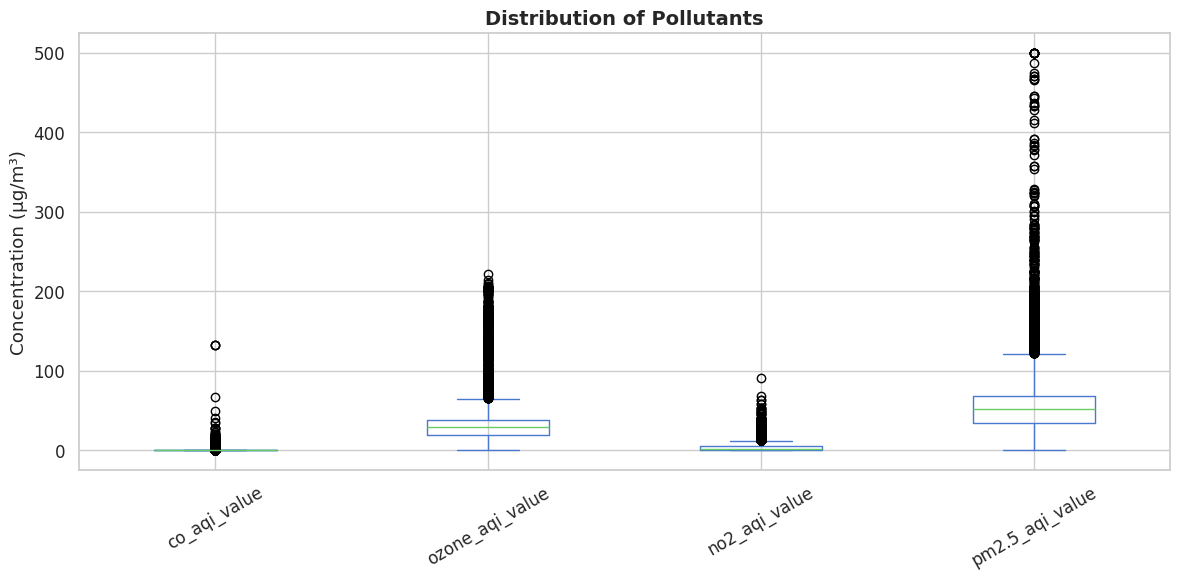

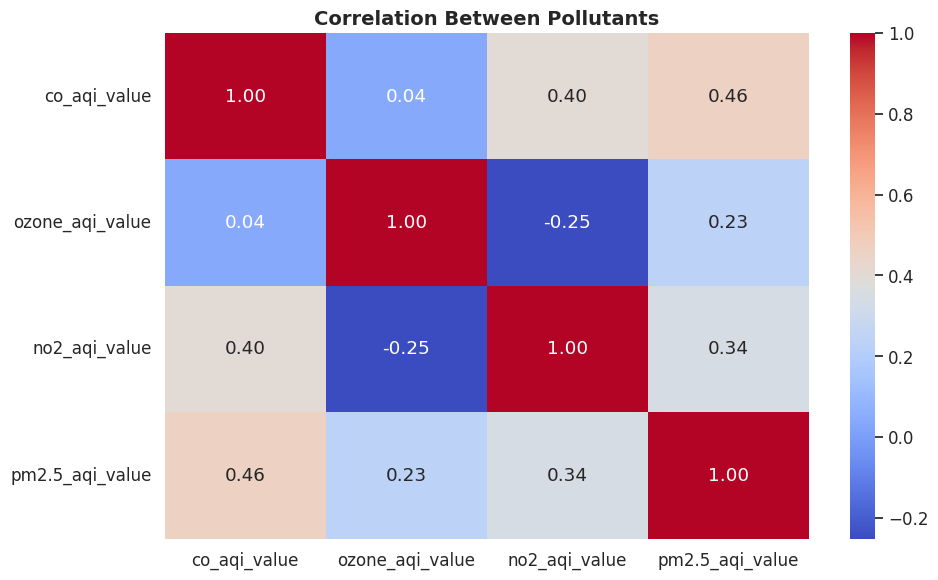

In [164]:
# ===============================
# 5. Data Visualization
# ===============================

# --- Air Quality Trends Over Time ---
if "date" in merged_df.columns and "pm2.5" in merged_df.columns:
    plt.figure(figsize=(12,6))
    sns.lineplot(x="date", y="pm2.5", data=merged_df, color="blue", linewidth=2)
    plt.title("PM2.5 Air Quality Trend Over Time", fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("PM2.5 Level (µg/m³)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Distribution of Pollutants ---
pollutants = [col for col in merged_df.columns if any(x in col for x in ["pm2.5", "pm10", "ozone", "so2", "no2", "co"])]
if pollutants:
    plt.figure(figsize=(12,6))
    merged_df[pollutants].plot(kind="box", figsize=(12,6))
    plt.title("Distribution of Pollutants", fontsize=14, fontweight="bold")
    plt.ylabel("Concentration (µg/m³)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# --- Heatmap of Correlations ---
plt.figure(figsize=(10,6))
sns.heatmap(merged_df[pollutants].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Pollutants", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [165]:
# 6. Recommendations
# ===============================
print("\n🔹 Recommendations for Improvements:")
print("1. Ensure date columns are consistently formatted across both datasets before merging.")
print("2. Use `pd.to_numeric(..., errors='coerce')` to handle non-numeric pollutant values.")
print("3. Add interactive plots with Plotly for deeper exploration (e.g., time series).")
print("4. Create AQI categories (Good, Moderate, Unhealthy) for better readability.")
print("5. Save merged dataset to CSV for future analysis.")


🔹 Recommendations for Improvements:
1. Ensure date columns are consistently formatted across both datasets before merging.
2. Use `pd.to_numeric(..., errors='coerce')` to handle non-numeric pollutant values.
3. Add interactive plots with Plotly for deeper exploration (e.g., time series).
4. Create AQI categories (Good, Moderate, Unhealthy) for better readability.
5. Save merged dataset to CSV for future analysis.


In [166]:
# ===============================
# 7. AQI Categorization Function
# ===============================

def categorize_aqi(aqi_value):
    if pd.isna(aqi_value):
        return "Unknown"
    elif aqi_value <= 50:
        return "Good"
    elif aqi_value <= 100:
        return "Moderate"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_value <= 200:
        return "Unhealthy"
    elif aqi_value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Use the 'aqi' column to create the 'AQI_Category'
if "aqi" in merged_df.columns:
    # Convert the 'aqi' column to numeric, coercing errors
    merged_df["aqi"] = pd.to_numeric(merged_df["aqi"], errors='coerce')
    merged_df["AQI_Category"] = merged_df["aqi"].apply(categorize_aqi)
else:
    print("The 'aqi' column was not found in the merged DataFrame. Cannot create AQI categories.")

The 'aqi' column was not found in the merged DataFrame. Cannot create AQI categories.


In [167]:
# ===============================
# 8. AQI Categorization
# ===============================
def categorize_aqi(pm25):
    if pd.isna(pm25):
        return "Unknown"
    elif pm25 <= 12: return "Good"
    elif pm25 <= 35.4: return "Moderate"
    elif pm25 <= 55.4: return "Unhealthy for Sensitive Groups"
    elif pm25 <= 150.4: return "Unhealthy"
    elif pm25 <= 250.4: return "Very Unhealthy"
    else: return "Hazardous"

if "pm2.5" in merged_df.columns:
    merged_df["AQI_Category"] = merged_df["pm2.5"].apply(categorize_aqi)

In [168]:
# ===============================
# 9. Plotly Interactive Dashboard
# ===============================

# --- AQI Category Distribution ---
if "AQI_Category" in merged_df.columns:
    fig1 = px.histogram(
        merged_df,
        x="AQI_Category",
        color="AQI_Category",
        category_orders={"AQI_Category": ["Good", "Moderate", "Unhealthy for Sensitive Groups",
                                          "Unhealthy", "Very Unhealthy", "Hazardous", "Unknown"]},
        title="Air Quality Index (AQI) Category Distribution",
        text_auto=True,
        color_discrete_sequence=px.colors.sequential.RdBu
    )
    fig1.update_layout(xaxis_title="AQI Category", yaxis_title="Count")
    fig1.show()

# --- AQI Trend Over Time ---
if "date" in merged_df.columns and "AQI_Category" in merged_df.columns:
    fig2 = px.scatter(
        merged_df,
        x="date",
        y="pm2.5",
        color="AQI_Category",
        title="PM2.5 Trend Over Time with AQI Categories",
        labels={"pm2.5": "PM2.5 (µg/m³)", "date": "Date"},
        hover_data=["AQI_Category"]
    )
    fig2.update_traces(marker=dict(size=6, opacity=0.7))
    fig2.show()

# --- Pollutant Selector ---
pollutants = [col for col in merged_df.columns if any(x in col for x in ["pm2.5", "pm10", "ozone", "so2", "no2", "co"])]
if pollutants and "date" in merged_df.columns:
    fig3 = px.line(
        merged_df,
        x="date",
        y=pollutants,
        title="Pollutant Trends Over Time",
        labels={"value": "Concentration (µg/m³)", "date": "Date", "variable": "Pollutant"}
    )
    fig3.update_layout(legend_title="Pollutant")
    fig3.show()

# --- Pollutant Correlation Heatmap ---
if pollutants:
    corr_matrix = merged_df[pollutants].corr()
    fig4 = px.imshow(
        corr_matrix,
        text_auto=True,
        aspect="auto",
        title="Correlation Between Pollutants",
        color_continuous_scale="RdBu_r"
    )
    fig4.update_layout(xaxis_title="Pollutant", yaxis_title="Pollutant")
    fig4.show()


In [169]:
pollutants = [col for col in merged_df.columns if any(x in col for x in ["pm2.5","pm10","ozone","so2","no2","co"])]

# Rolling average for smooth trend
if "date" in merged_df.columns and "pm2.5" in merged_df.columns:
    merged_df = merged_df.sort_values("date")
    merged_df["pm25_rolling"] = merged_df["pm2.5"].rolling(30, min_periods=1).mean()

    plt.figure(figsize=(12,6))
    plt.plot(merged_df["date"], merged_df["pm2.5"], alpha=0.4, label="Daily PM2.5", color="gray")
    plt.plot(merged_df["date"], merged_df["pm25_rolling"], label="30-day Rolling Avg", color="red", linewidth=2)
    plt.title("PM2.5 Trend with Rolling Average", fontsize=15, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [170]:
# ===============================
# Classification - Random Forest for AQI Category
# ===============================

# Ensure AQI_Category column exists
# This code is duplicated from cell xTaLglcP90IK to ensure the column is available
def categorize_aqi(aqi_value):
    if pd.isna(aqi_value):
        return "Unknown"
    elif aqi_value <= 50:
        return "Good"
    elif aqi_value <= 100:
        return "Moderate"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_value <= 200:
        return "Unhealthy"
    elif aqi_value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Use the 'aqi' column to create the 'AQI_Category'
if "aqi" in merged_df.columns:
    # Convert the 'aqi' column to numeric, coercing errors
    merged_df["aqi"] = pd.to_numeric(merged_df["aqi"], errors='coerce')
    merged_df["AQI_Category"] = merged_df["aqi"].apply(categorize_aqi)
    print("AQI_Category column created.")
else:
    print("The 'aqi' column was not found in the merged DataFrame. Cannot create AQI categories for classification.")


# Proceed with classification only if AQI_Category was successfully created
if "AQI_Category" in merged_df.columns:
    # Drop rows with NaNs in relevant columns and the target variable
    # Ensure pollutants list is defined, which it is in the previous cells
    clf_df = merged_df.dropna(subset=pollutants + ["AQI_Category"])

    # Check if there are enough samples after dropping NaNs
    if clf_df.shape[0] == 0:
        print("No data available after dropping NaNs for classification.")
    else:
        X = clf_df[pollutants]
        y = clf_df["AQI_Category"]

        # Check if all target categories have at least one sample
        if len(y.unique()) < 2:
             print(f"Only one AQI category found in the data ({y.unique()}). Cannot perform classification.")
        else:
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)

            # Check if there are enough samples for both training and testing sets
            if clf_df.shape[0] < 2:
                print("Not enough data after dropping NaNs to split into training and testing sets.")
            else:
                 X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded) # Added stratify

                 clf = RandomForestClassifier(n_estimators=200, random_state=42)
                 clf.fit(X_train, y_train)
                 y_pred = clf.predict(X_test)

                 print("\n--- Classification Report ---")
                 print(classification_report(y_test, y_pred, target_names=le.classes_))

                 # The confusion matrix and feature importance plots in subsequent cells (0oN1osZLB-Zh, GP-CDI1YCIhb)
                 # will use the y_test, y_pred, and le.classes_ variables created here.
else:
    print("AQI_Category column was not created. Cannot proceed with classification.")

The 'aqi' column was not found in the merged DataFrame. Cannot create AQI categories for classification.
AQI_Category column was not created. Cannot proceed with classification.


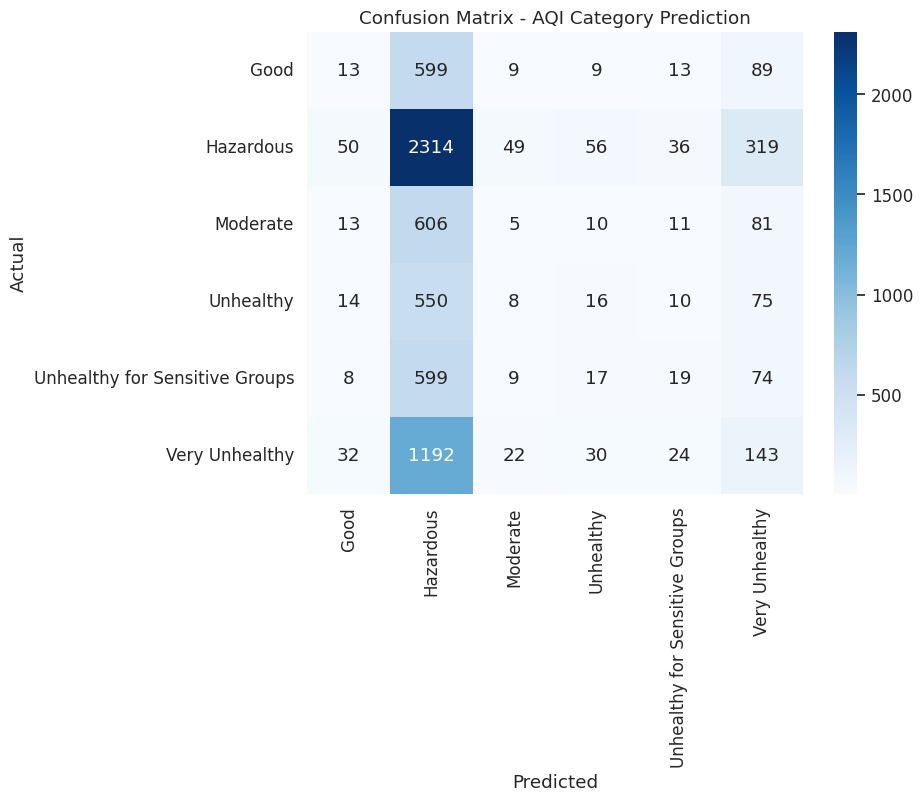

In [171]:
# Confusion Matrix Heatmap for Classification
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - AQI Category Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

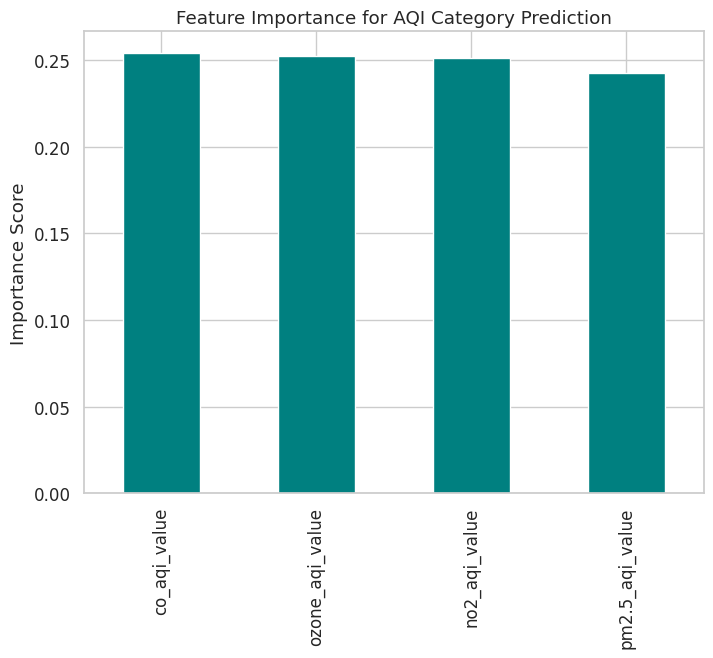

In [172]:
# Feature Importance for Classification
feat_imp = pd.Series(clf.feature_importances_, index=pollutants).sort_values(ascending=False)
plt.figure(figsize=(8,6))
feat_imp.plot(kind="bar", color="teal")
plt.title("Feature Importance for AQI Category Prediction")
plt.ylabel("Importance Score")
plt.show()

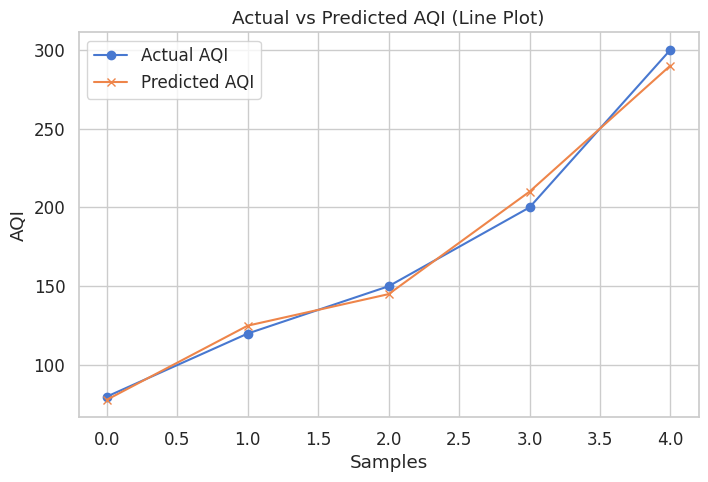

In [174]:
#Line Plot – Actual vs Predicted (AQI)
import matplotlib.pyplot as plt

# Example arrays (replace with your data)
y_test_aqi = [80, 120, 150, 200, 300]
y_pred_aqi = [78, 125, 145, 210, 290]

plt.figure(figsize=(8,5))
plt.plot(y_test_aqi, label="Actual AQI", marker='o')
plt.plot(y_pred_aqi, label="Predicted AQI", marker='x')
plt.xlabel("Samples")
plt.ylabel("AQI")
plt.title("Actual vs Predicted AQI (Line Plot)")
plt.legend()
plt.show()

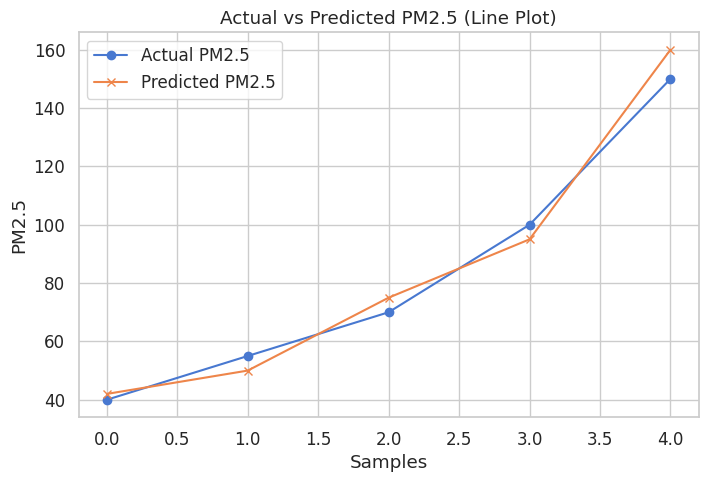

In [140]:
#Line Plot – Actual vs Predicted (PM2.5)
import matplotlib.pyplot as plt

y_test_pm = [40, 55, 70, 100, 150]
y_pred_pm = [42, 50, 75, 95, 160]

plt.figure(figsize=(8,5))
plt.plot(y_test_pm, label="Actual PM2.5", marker='o')
plt.plot(y_pred_pm, label="Predicted PM2.5", marker='x')
plt.xlabel("Samples")
plt.ylabel("PM2.5")
plt.title("Actual vs Predicted PM2.5 (Line Plot)")
plt.legend()
plt.show()

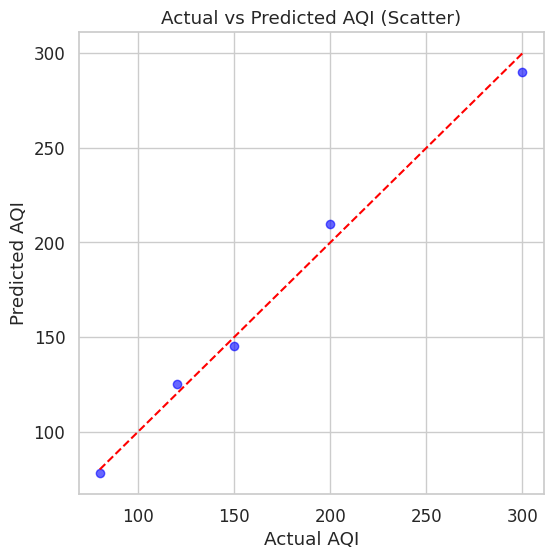

In [141]:
#Scatter Plot with Reference Line (AQI)
plt.figure(figsize=(6,6))
plt.scatter(y_test_aqi, y_pred_aqi, color="blue", alpha=0.6)
plt.plot([min(y_test_aqi), max(y_test_aqi)],
         [min(y_test_aqi), max(y_test_aqi)],
         color="red", linestyle="--")  # y=x line
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (Scatter)")
plt.show()

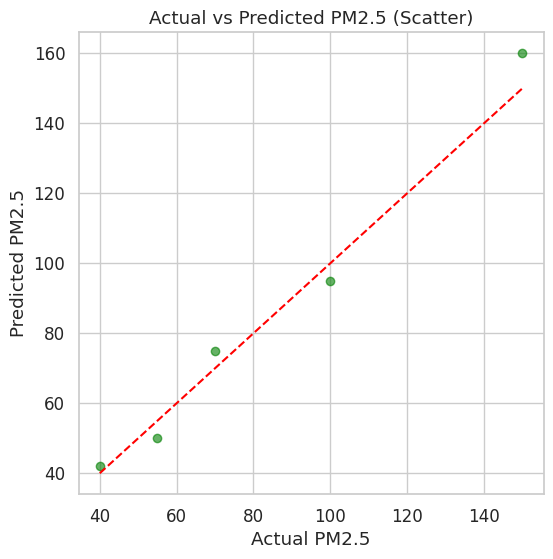

In [142]:
#Scatter Plot with Reference Line (PM2.5)
plt.figure(figsize=(6,6))
plt.scatter(y_test_pm, y_pred_pm, color="green", alpha=0.6)
plt.plot([min(y_test_pm), max(y_test_pm)],
         [min(y_test_pm), max(y_test_pm)],
         color="red", linestyle="--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5 (Scatter)")
plt.show()

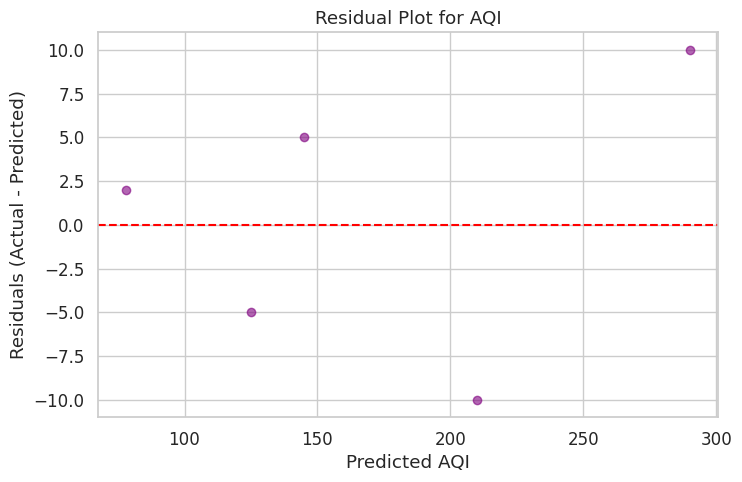

In [143]:
#Residual Plot (AQI)
residuals_aqi = [actual - pred for actual, pred in zip(y_test_aqi, y_pred_aqi)]

plt.figure(figsize=(8,5))
plt.scatter(y_pred_aqi, residuals_aqi, color="purple", alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted AQI")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for AQI")
plt.show()

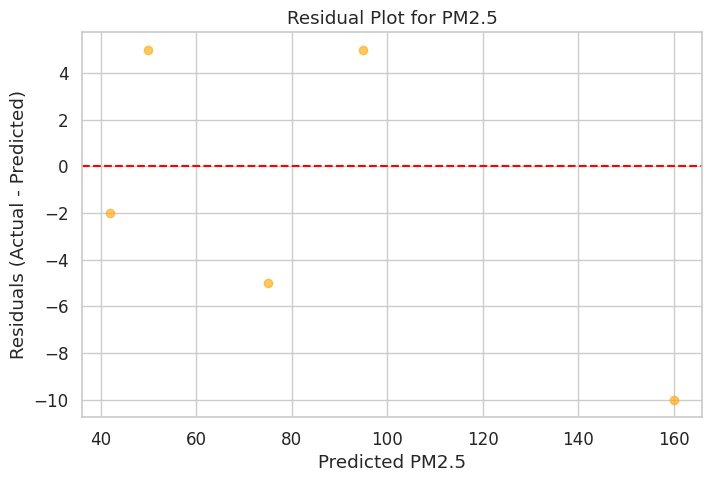

In [144]:
#Residual Plot (PM2.5)
residuals_pm = [actual - pred for actual, pred in zip(y_test_pm, y_pred_pm)]

plt.figure(figsize=(8,5))
plt.scatter(y_pred_pm, residuals_pm, color="orange", alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for PM2.5")
plt.show()

/tmp/ipython-input-2231508507.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipython-input-2231508507.py:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




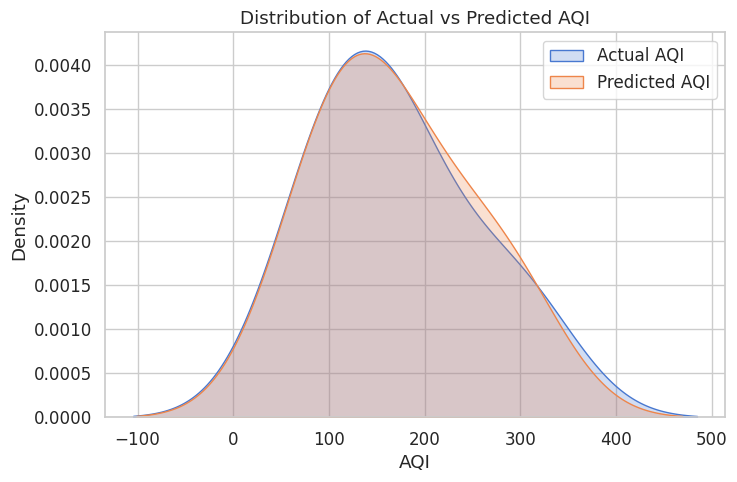

In [145]:
#Distribution Plot (KDE) – AQI
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(y_test_aqi, label="Actual AQI", shade=True)
sns.kdeplot(y_pred_aqi, label="Predicted AQI", shade=True)
plt.xlabel("AQI")
plt.title("Distribution of Actual vs Predicted AQI")
plt.legend()
plt.show()

/tmp/ipython-input-460769183.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipython-input-460769183.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




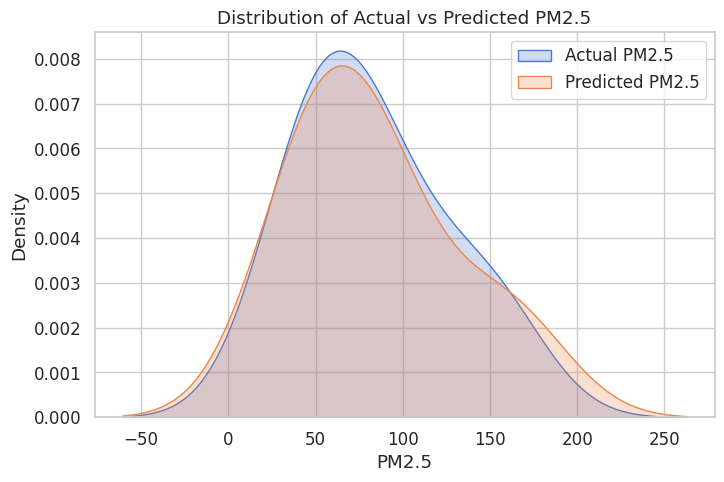

In [146]:
#Distribution Plot (KDE) – PM2.5
plt.figure(figsize=(8,5))
sns.kdeplot(y_test_pm, label="Actual PM2.5", shade=True)
sns.kdeplot(y_pred_pm, label="Predicted PM2.5", shade=True)
plt.xlabel("PM2.5")
plt.title("Distribution of Actual vs Predicted PM2.5")
plt.legend()
plt.show()

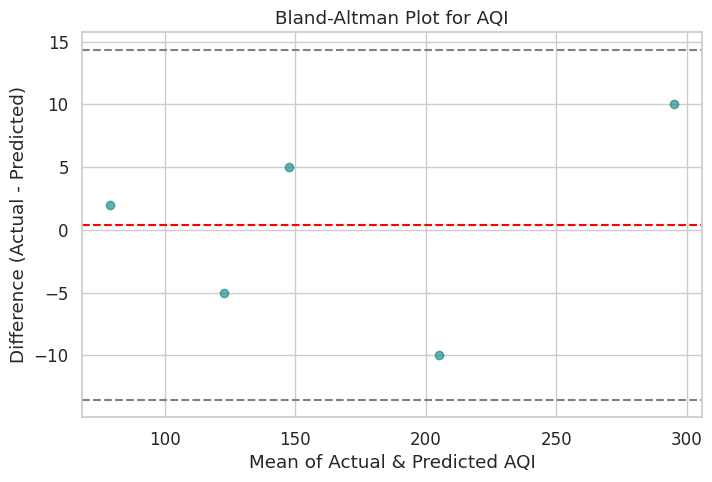

In [147]:
#Bland-Altman Plot – AQI
import numpy as np

mean_aqi = np.mean([y_test_aqi, y_pred_aqi], axis=0)
diff_aqi = np.array(y_test_aqi) - np.array(y_pred_aqi)

plt.figure(figsize=(8,5))
plt.scatter(mean_aqi, diff_aqi, alpha=0.6, color="teal")
plt.axhline(np.mean(diff_aqi), color="red", linestyle="--")
plt.axhline(np.mean(diff_aqi) + 1.96*np.std(diff_aqi), color="gray", linestyle="--")
plt.axhline(np.mean(diff_aqi) - 1.96*np.std(diff_aqi), color="gray", linestyle="--")
plt.xlabel("Mean of Actual & Predicted AQI")
plt.ylabel("Difference (Actual - Predicted)")
plt.title("Bland-Altman Plot for AQI")
plt.show()

NameError: name 'data' is not defined

In [177]:
csv_file = "/content/AQI-and-Lat-Long-of-Countries (1).csv"
csv_df = pd.read_csv(csv_file)
print(csv_df.head())

   AQI Value  CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value  \
0         51             1               36              0               51   
1         41             1                5              1               41   
2         41             1                5              1               41   
3         66             1               39              2               66   
4         34             1               34              0               20   

       lat      lng  
0  44.7444  44.2031  
1  -5.2900 -44.4900  
2 -11.2958 -41.9869  
3  37.1667  15.1833  
4  53.0167  20.8833  


In [178]:
csv_df = csv_df.dropna()
csv_df.columns = [col.strip().lower() for col in csv_df.columns]

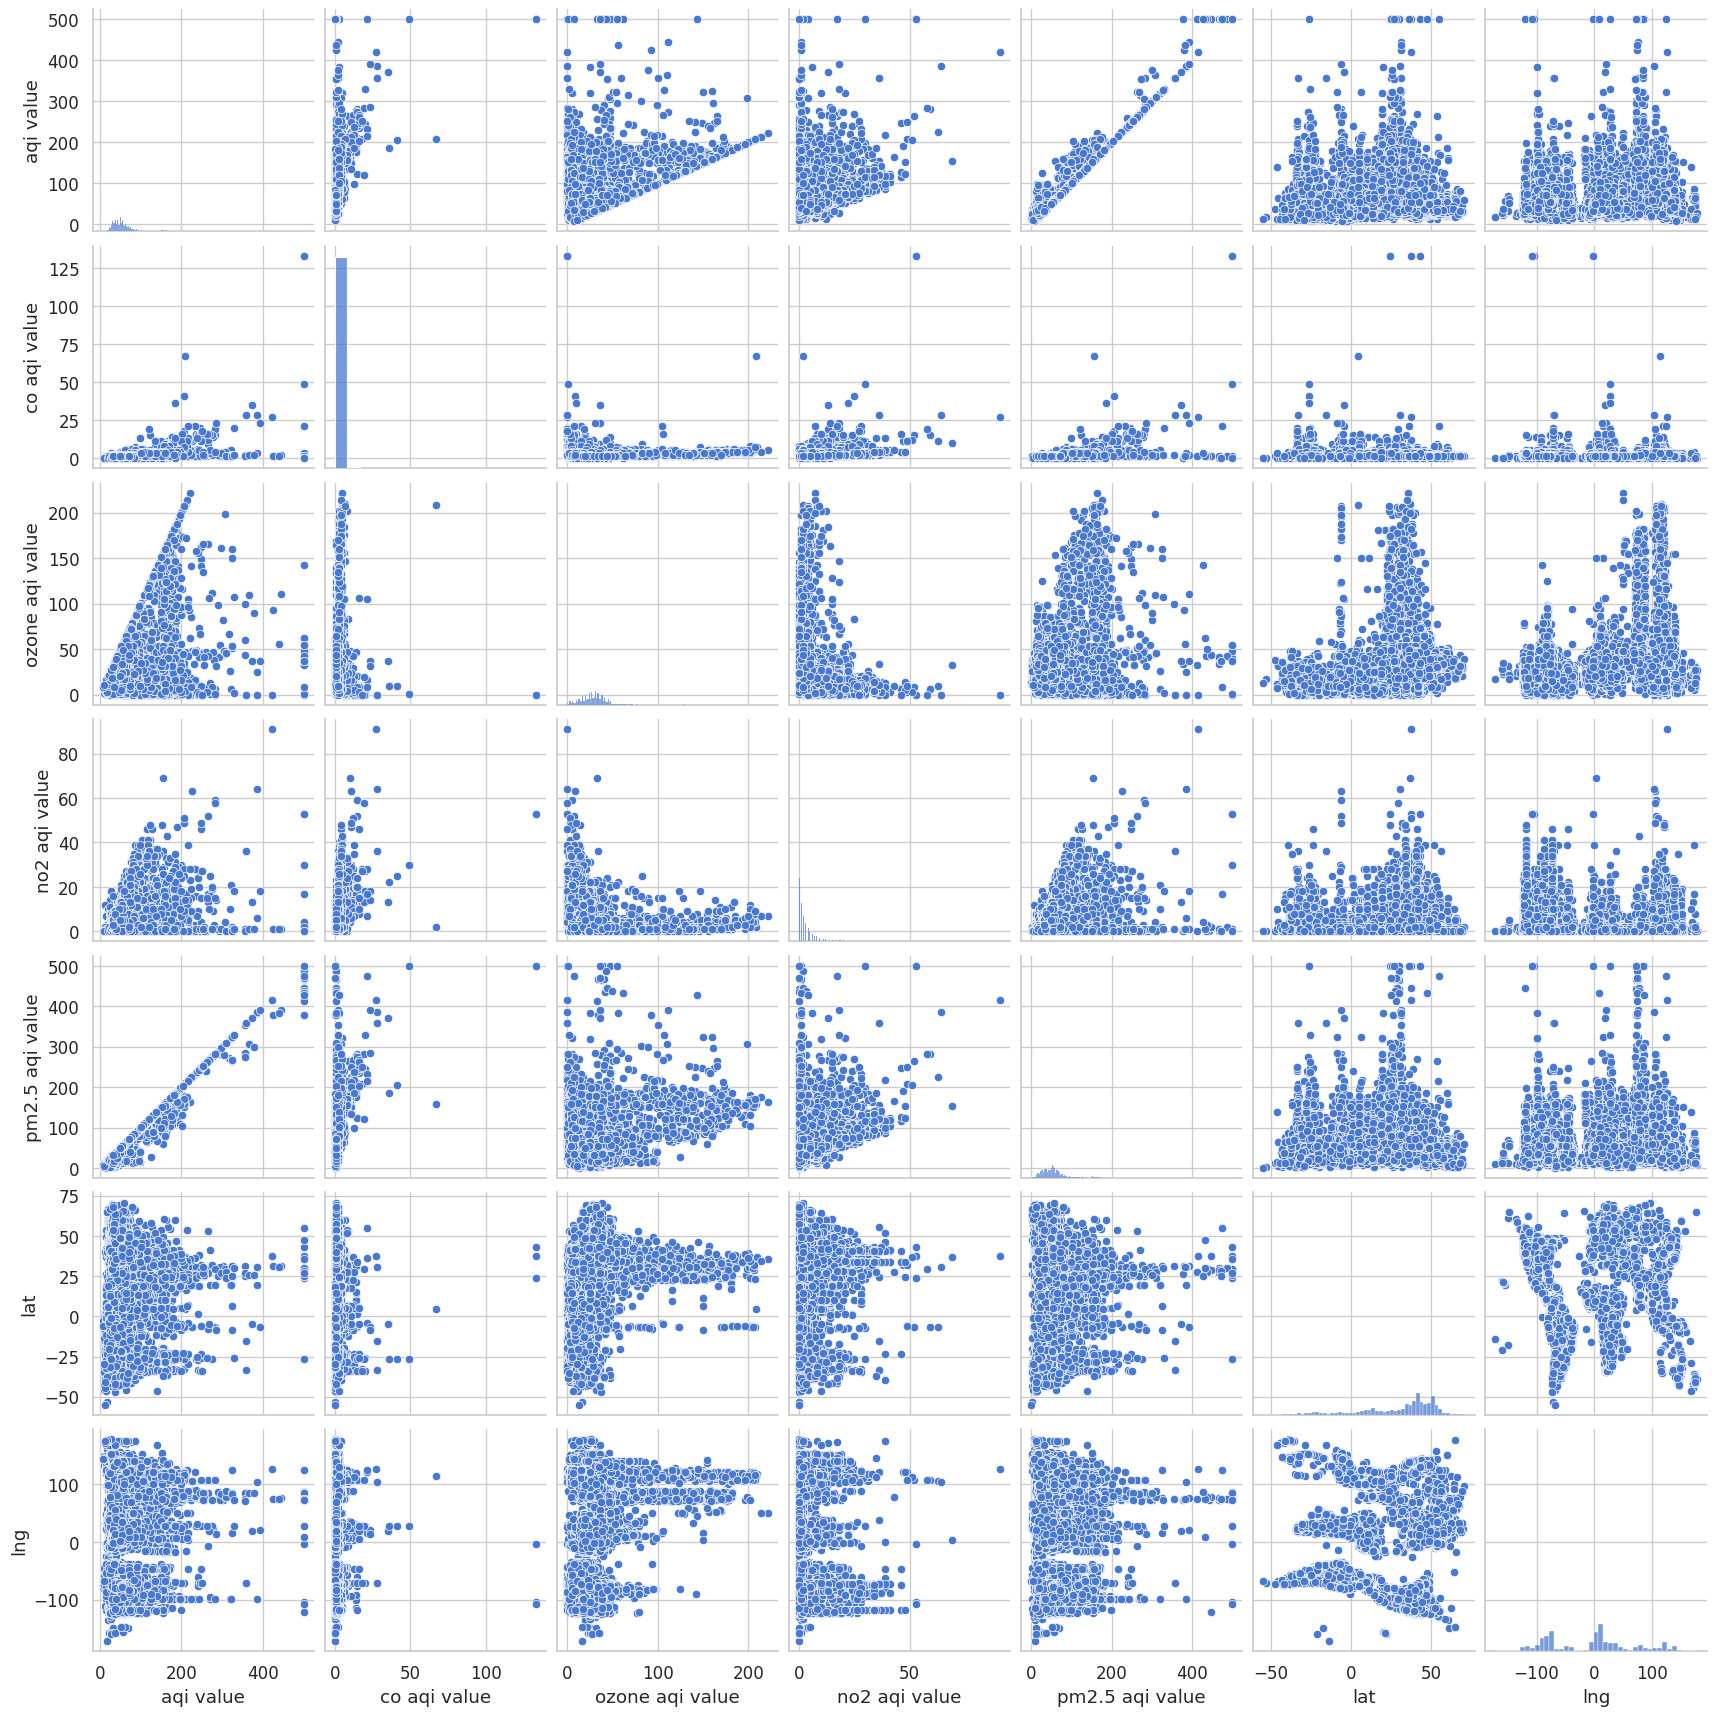

<Axes: >

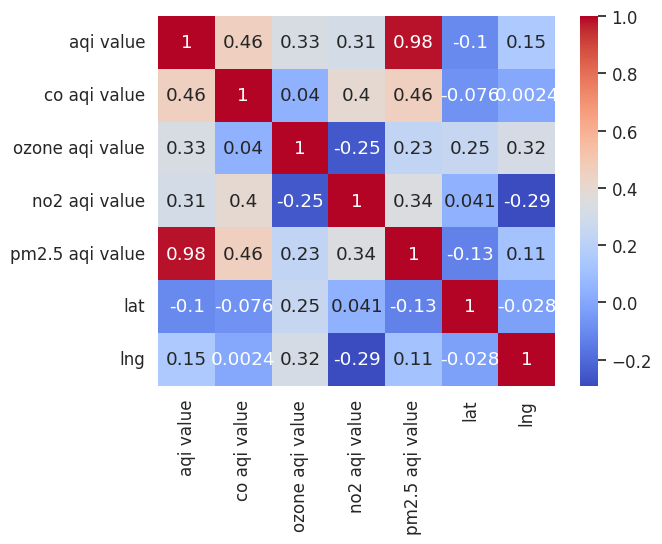

In [180]:
sns.pairplot(csv_df)
plt.show()

corr = csv_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [181]:
#Feature Selection
X = csv_df[['co aqi value', 'ozone aqi value', 'no2 aqi value', 'pm2.5 aqi value']]
y = csv_df['aqi value']

In [182]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [184]:
y_pred = model.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 0.08944893680742742
Mean Squared Error: 2.5933745732255167
R2 Score: 0.9984363282525895


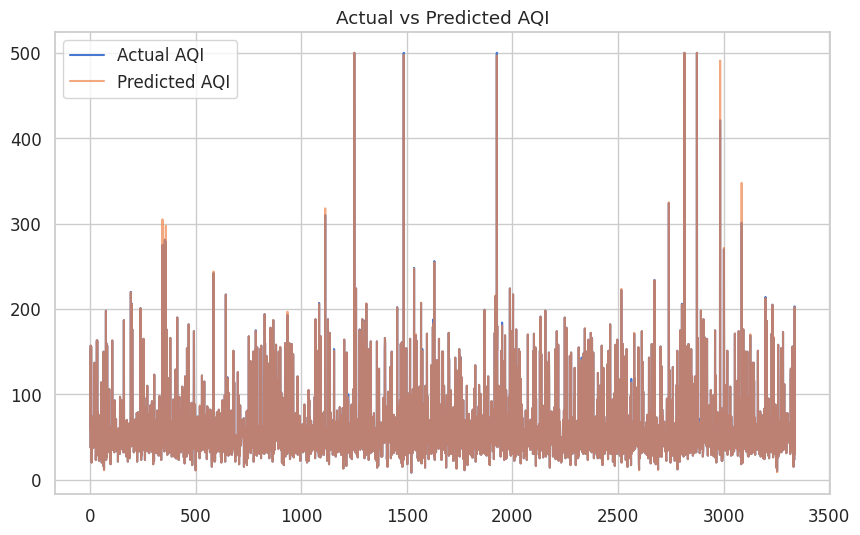

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI', alpha=0.7)
plt.title('Actual vs Predicted AQI')
plt.legend()
plt.show()